In [1]:
import os
import besos
from besos import sampling
from besos import eppy_funcs as ef
from besos import eplus_funcs as ep
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist, DependentParameter, CategoryParameter
from besos.objectives import MeterReader,time_series_values,EPResults
from besos.optimizer import NSGAII, df_solution_to_solutions
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from sub.min import *
import numpy as np

In [2]:
objectives = ['Electricity:Facility','DistrictCooling:Facility', 'DistrictHeating:Facility']
df_out3 = pd.read_csv("3_layer.csv", index_col=0)
np.random.seed(2)  # random seed grant us an comparable results obtained in each algorithm
df_out3.info()  # the panda framework display an easier to read matrix
data = df_out3[['Orientation','Ventilation','Shading','Insulation Thickness','Window to Wall Ratio','total (Q)']].values  # convert the values in the file into a matrix specifically an Ndarray

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Orientation               100 non-null    int64  
 1   Ventilation               100 non-null    float64
 2   Shading                   100 non-null    float64
 3   Insulation Thickness      100 non-null    float64
 4   Window to Wall Ratio      100 non-null    float64
 5   Electricity:Facility      100 non-null    float64
 6   DistrictCooling:Facility  100 non-null    float64
 7   DistrictHeating:Facility  100 non-null    float64
 8   total (Q)                 100 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 7.8 KB


In [3]:
Np, Nf = np.shape(data)
Np, Nf

(100, 6)

In [33]:
data_train = data[0:int(Np/2), :]  # the training data is 50% of the whole data set
data_val = data[int(Np/2):int(Np*0.75), :]  # validation data set 25%
data_test = data[int(Np*0.75):Np, :]  # test data set 25%

mean = np.mean(data_train, 0)  # returns a row of means
std = np.std(data_train, 0)  # returns a row of standard deviations
print("std deviation: ", std)

# standardizing our data means that an eventual offset will be not considered
data_train_norm = (data_train - mean)/std
data_val_norm = (data_val - mean)/std
data_test_norm = (data_test - mean)/std

std deviation:  [9.87378347e+01 6.00000000e-02 9.11376553e+00 1.34462904e-01
 2.17422791e-01 1.52173712e+01]


In [5]:
# checking if the mean and standard deviation are respected
mean_check = np.mean(data_train_norm, 0)  # returns a row of means
std_check = np.std(data_train_norm, 0)  # returns a row of standard deviations
mean_check, std_check

(array([ 5.77315973e-17,  0.00000000e+00, -1.11022302e-18, -5.55111512e-17,
         5.77315973e-17,  1.52100554e-16]),
 array([1., 1., 1., 1., 1., 1.]))

In [6]:
F0 = 5 # F0 is the feature we want to choose in order to be the regressand in our case  it is the Total Q
# regressands y and regressors X set up
y_train = data_train_norm[:, F0]
X_train = np.delete(data_train_norm, F0, 1)
y_val = data_val_norm[:, F0]
X_val = np.delete(data_val_norm, F0, 1)
y_test = data_test_norm[:, F0]
X_test = np.delete(data_test_norm, F0, 1)

In [7]:
# with the slicing operation we have to keep in mind to check the resulting shape
# print(np.shape(y_train)) to check
y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
# some inizialization before starting the algorithms
logx = 0
logy = 1
Nit = 30
gamma = 1e-5
mse_train = np.zeros((6, 1), dtype=float)
mse_val = np.zeros((6, 1), dtype=float)
mse_test = np.zeros((6, 1), dtype=float)

Steepest Descent algorithm  :
the optimum weight vector is: 
[[-0.01942819]
 [ 0.02405054]
 [ 0.02271791]
 [-0.77846603]
 [ 0.14416589]]


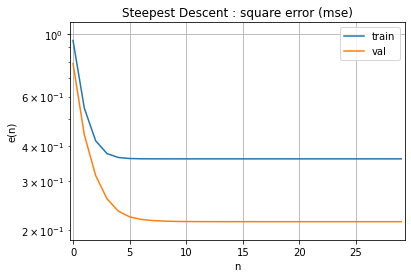

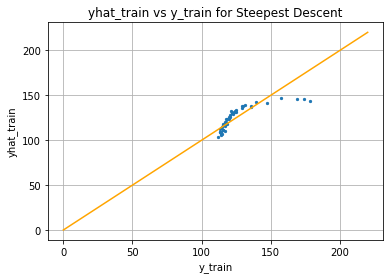

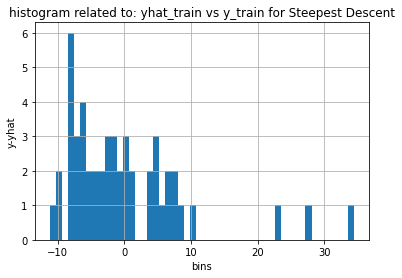

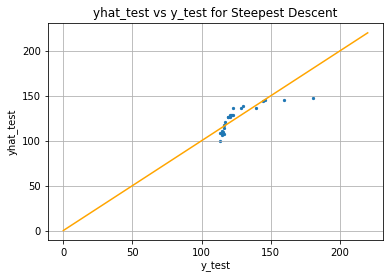

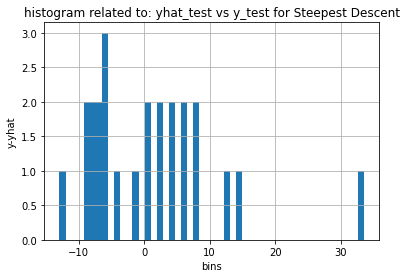

In [8]:
sd = SolveSteepDesc(y_train, X_train, y_val, X_val, y_test, X_test)
mse_train[2], mse_val[2], mse_test[2] = sd.run(Nit)
sd.print_result('Steepest Descent algorithm')
sd.plot_err('Steepest Descent : square error', logy, logx)
sd.print_hat('yhat_train vs y_train for Steepest Descent', 'yhat_train','y_train',y_train, X_train,mean[F0],std[F0])
sd.print_hat('yhat_test vs y_test for Steepest Descent', 'yhat_test', 'y_test', y_test, X_test, mean[F0],std[F0])

In [15]:
w=np.array([[-0.01942819],
 [ 0.02405054],
 [ 0.02271791],
 [-0.77846603],
 [ 0.14416589],])
w.shape

(5, 1)

In [30]:
samples_temp = []
orientation_values = [0,90,180,270] 
wwr_values = np.linspace(0.01,0.9,100)
ventilation_values = [0, 0.12] 
tickness_values = np.linspace(0.01,0.5,50)
shading = np.linspace(0,30,31)
for ori in orientation_values:
    for wwr_ in wwr_values:
        for vent in ventilation_values:
            for tickness in tickness_values:
                for shade in shading:
                    samples_temp.append({'Orientation': ori,
                                         'Ventilation': vent,
                                         'Shading': shade,
                                         'Insulation Thickness': tickness,
                                         'Window to Wall Ratio': wwr_,})
samples = pd.DataFrame.from_dict(samples_temp)
samples

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio
0,0,0.00,0.0,0.01,0.01
1,0,0.00,1.0,0.01,0.01
2,0,0.00,2.0,0.01,0.01
3,0,0.00,3.0,0.01,0.01
4,0,0.00,4.0,0.01,0.01
...,...,...,...,...,...
1239995,270,0.12,26.0,0.50,0.90
1239996,270,0.12,27.0,0.50,0.90
1239997,270,0.12,28.0,0.50,0.90
1239998,270,0.12,29.0,0.50,0.90


In [34]:
test_data=samples.values
test_data_norm=(test_data -mean[:5])/std[:5]
# checking if the mean and standard deviation are respected
mean_check = np.mean(test_data_norm, 0)  # returns a row of means
std_check = np.std(test_data_norm, 0)  # returns a row of standard deviations
mean_check, std_check

(array([ 0.07292038,  0.        ,  0.1402517 ,  0.05069636, -0.1058248 ]),
 array([1.01909323, 1.        , 0.98140246, 1.07322312, 1.19354118]))

In [39]:
total_Q = np.dot(test_data_norm,w)
total_Q_denorm = (total_Q * std[-1])+mean[-1]
total_Q_denorm.min()

96.54543539289831

In [40]:
total_Q.argmin()

931519

In [43]:
with np.printoptions(precision=3, suppress=True):
    print(test_data[total_Q.argmin(),:])

[270.     0.     0.     0.5    0.01]
